In [100]:
#Importing required libraries
import pandas as pd
import numpy as np
from scipy.linalg import norm
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg
import time
import matplotlib.pyplot as plt
from sys import getsizeof
plt.style.use('ggplot')
%matplotlib inline

# Data loading and Conversion to Utility Matrix
The data is loaded into pandas dataframe and the relevant information is extracted to construct an MxN utility matrix in the form of a numpy matrix were M= No. of Users and N= No of movies.

In [26]:
#reading the data into a pandas dataframe
links=pd.read_csv('links.csv')
ratings=pd.read_csv('ratings.csv')
movies=pd.read_csv('movies.csv')
tags=pd.read_csv('tags.csv')

In [27]:
links.head() 

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [28]:
links.shape # implies 9125 is the number of movies

(9125, 3)

In [29]:
ratings.head() # implies 100004 non zero values will be present in the matrix

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [30]:
ratings.shape

(100004, 4)

In [31]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
mov=movies['movieId'].tolist()

In [33]:
# dictionary idToIndex hashes movie id to a continuous index from 1 to 9125
idToIndex={}             
for i in xrange(len(mov)):
    idToIndex[mov[i]]=i           

In [34]:
len(idToIndex.keys())

9125

In [35]:
N=movies.shape[0] #N=number of columns in MxN utility matrix

In [36]:
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [37]:
M=671

In [38]:
#Finally constructing the matrix iterating over rows of ratings data frame
A=np.zeros((M,N))
for index, row in ratings.iterrows():
    userid= int(row['userId'])
    movieid=int(row['movieId'])
    if idToIndex[movieid]<=9125:
        A[userid-1,idToIndex[movieid]]=row['rating']
    

In [39]:
np.count_nonzero(A)  #sanity check

100004

# Function to compute eigen values and eigen vectors
For calculating SVD, we need the eigenpairs of AAT and ATA. A generalised power iteration function is used here to do that. Power iteration actually just calulates the principal eigenvector, but we iteratively keep on reducting the matrix to find eigenvectors corresponding to largest k eigenvalues.

In [40]:
A=np.matrix(A)
AAT=A*A.T
ATA=A.T*A

In [42]:
# This function computes the eigenvalues and eigenvectors using power iteration method
# Arguments:
#     M: Square Matrix
#     k: Number of eigenpairs we want to calculate
# Returns:
#     Val: list of k eigenvalues we want to calculate
#     Vec: list of corresponding eigenvectors as numpy column arrays
def getEigenPairs(M,k):
    x=np.random.randn((M.shape[0]))
    Val=[]
    Vec=[]
    x=x.reshape((M.shape[0],1)) 
    for i in xrange(k):
        #M=np.matrix(M)
        for run in xrange(1000):
            V=M*x                
            nor=norm(V)
            if nor!=0:
                
                x_new=V/nor
                x=x_new

        eVec=x
        y=x.reshape((1,M.shape[0]))
        y=np.matrix(y)
        x=x.reshape((M.shape[0],1))
        x=np.matrix(x)

        eVal=y*M*x
        
        eVal=np.asscalar(eVal)
        if eVal>0.1:
            
            Val.append(eVal)
            Vec.append(eVec)
        else:
            Val.append(0)
            Vec.append(eVec)
    
        M=M-eVal*x*y   
    return Val,Vec

In [44]:
def signU(A,u,v):
    x=A*v
    if x[0]/u[0]>0:
        return 1
    else:
        return -1

In [45]:
# Calculates Singular Value Decomposition of the matrix.
# Arguments:
#     AAT,ATA:
#         A*A(Transpose) and A(transpose)*A
#     k: Rank of SVD we want to compute/ no of singular values we want to consider
#         /No of latent dimensions we want to break our space into
def SVD(A,AAT,ATA,k):  
    
    #Fetch eigenvalues and eigenvectors for AAT and ATA
   
    L1,V1=getEigenPairs(AAT,k)
    L2,V2=getEigenPairs(ATA,k)
    
    print 'Eigenvectors and EigenValues calculated'
    
    print'proceeding...'
    
    
    for i in xrange(k):
            sgn=signU(A,V1[i],V2[i])
            V1[i]=sgn*V1[i]
        
    
    print 'stacking U and V matrices'
    #Create U Matrix:
    U=V1[0]
    for i in xrange(1,len(V1)):
        U=np.column_stack((U,V1[i]))
        
    
    
    #Create V matrix:
    V=V2[0]
    for i in xrange(1,len(V2)):
        V=np.column_stack((V,V2[i]))
        
        
        
        
    V=np.matrix(V)
    U=np.matrix(U)
    
    
    
    
    
    
    print 'constructing sigma matrix'    
    #construct the sigma matrix:

    sigma=np.zeros((k,k))
    sigma=np.matrix(sigma)
    for i in xrange(k):
        if L1[i]>0:
            sigma[i,i]=pow(L1[i],0.5)
        else:
            sigma[i,i]=0
            
        
    sigma=np.matrix(sigma)
    print 'done'
    return U, sigma, V

In [48]:
#Sparse converting A, AAT and ATA into sparse csr matrices
sA=sparse.csr_matrix(A)
sAAT=sparse.csr_matrix(AAT)
sATA=sparse.csr_matrix(ATA)

In [179]:
#Tracking how the computation time increases with increase in k

timeTrajectory=[]
for i in xrange(10,40,5):
    start = time.time()

    u,s,v=SVD(AAT,ATA,i)


    end = time.time()
    print 'time required to compute SVD for with rank ' +str(i)+':'
    deltaT=(end - start)
    timeTrajectory.append(deltaT)
    print deltaT
    
    

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 10:
438.680305004
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 15:
640.328330994
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 20:
882.201025009
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 25:
1087.63093901
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 30:
1262.57298398
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD 

In [180]:
for i in xrange(40,80,5):
    start = time.time()

    u,s,v=SVD(AAT,ATA,i)


    end = time.time()
    print 'time required to compute SVD for with rank ' +str(i)+':'
    deltaT=(end - start)
    timeTrajectory.append(deltaT)
    print deltaT

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 40:
1791.36124611
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 45:
2082.20022988
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute SVD for with rank 50:
2179.87523603


KeyboardInterrupt: 

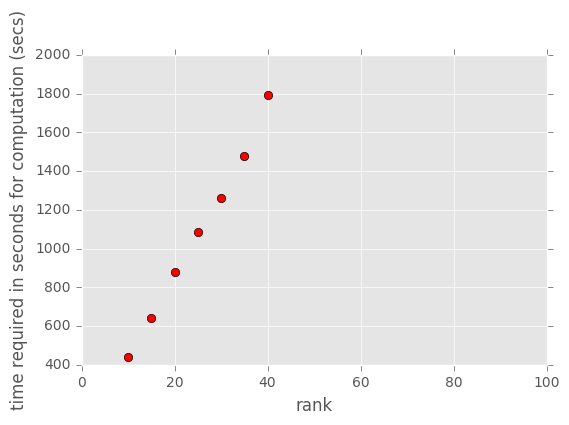

In [221]:
#plot of computation time in seconds versus the value of k. Clearly more time will be required for
#large k values
plt.plot([10,15,20,25,30,35,40,45,50], timeTrajectory, 'ro')
plt.axis([0, 100, 400, 2000])
plt.xlabel('rank')
plt.ylabel('time required in seconds for computation (secs)')
plt.show()

# CUR Decomposition


In [49]:
#for C and R matrices of o


#pf for rows:
pfr=[]
for i in xrange(A.shape[0]):
    arr=A[i,:]
    p=np.linalg.norm(arr)
    pfr.append(p)
total=sum(pfr)
for i in xrange(len(pfr)):
    pfr[i]=pfr[i]/total
    
    
   
pfc=[]
for i in xrange(A.shape[1]):
    arr=A[:,i]
    p=np.linalg.norm(arr)
    pfc.append(p)  
total=sum(pfc)
for i in xrange(len(pfc)):
    pfc[i]=pfc[i]/total

In [50]:
sum(pfr)  #sanity check

1.0000000000000007

In [51]:
sum(pfc)   #sanity check

1.0000000000000051

In [55]:
def getU(W):
    WWT=W*W.T
    WTW=W.T*W
    u,s,v=SVD(W,WWT,WTW,W.shape[0])
    for i in xrange(s.shape[0]):
        if s[i,i]!=0:
            s[i,i]=1.0/s[i,i]
    s=np.power(s,2)
    return v*s*u.T

In [56]:
def getCUR(A,r):
    rowIndex=np.random.choice(A.shape[0],r,pfr)
    columnIndex=np.random.choice(A.shape[1],r,pfc)
    
    C=A[:,columnIndex[0]]
    columnIndex2=columnIndex[1:]
    for index in columnIndex2:
        C=np.column_stack((C,A[:,index]))
    
    R=A[rowIndex[0],:]
    rowIndex2=rowIndex[1:]
    for index in rowIndex2:
        R=np.vstack((R,A[index,:]))
        
    W=np.zeros((r,r))
    W=np.matrix(W)
    for i in xrange(W.shape[0]):
        for j in xrange(W.shape[1]):
            row=rowIndex[i]
            column=columnIndex[j]
            W[i,j]=A[row,column]
    W2=getU(W)        
    return C, W2, R
    

 

In [57]:
C,W,R=getCUR(A,100)

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done


In [58]:
C.shape

(671, 100)

In [59]:
R.shape

(100, 9125)

In [60]:
W.shape

(100, 100)

In [62]:
norm(A-C*W*R)

1201.217394393673

In [63]:
timeTrajectoryCUR=[]
for i in xrange(20,200,20):
    start = time.time()

    c,u,r=getCUR(A,i)


    end = time.time()
    print 'time required to compute CUR for with rank ' +str(i)+':'
    deltaT=(end - start)
    timeTrajectoryCUR.append(deltaT)
    print deltaT
    

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR for with rank 20:
0.794549942017
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR for with rank 40:
1.7839319706
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR for with rank 60:
2.84851717949
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR for with rank 80:
4.1482629776
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR for with rank 100:
5.33988904953
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
time required to compute CUR 

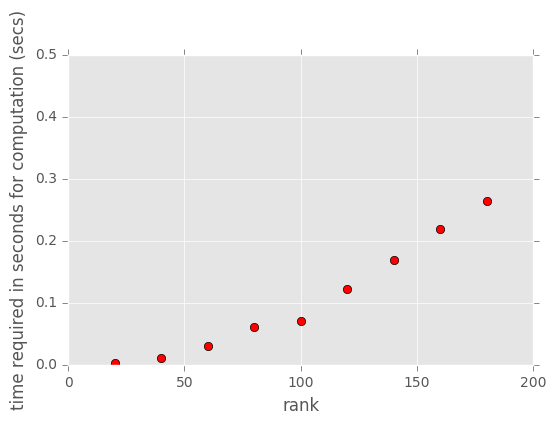

In [223]:
plt.plot([20,40,60,80,100,120,140,160,180], timeTrajectoryCUR, 'ro')
plt.axis([0,200 , 0, 0.5])
plt.xlabel('rank')
plt.ylabel('time required in seconds for computation (secs)')
plt.show()

In [65]:
memoryTrajectory=[]
memoryTrajectoryCUR=[]
reconsError=[]
reconsErrorCUR=[]

for i in xrange(10,50,10):
    
    c,u,r=getCUR(A,i)
    U,S,V=SVD(A,AAT,ATA,i)
    A_rec_svd=U*S*V.T
    A_rec_cur=c*u*r

    errSVD=norm(A-A_rec_svd)
    errCUR=norm(A-A_rec_cur)
    
    c=sparse.csr_matrix(c)
    u=sparse.csr_matrix(u)
    r=sparse.csr_matrix(r)
    
    memCUR=getsizeof(c)+getsizeof(u)+getsizeof(r)
    memSVD=getsizeof(U)+getsizeof(S)+getsizeof(V)
    
    memoryTrajectory.append(memSVD)
    memoryTrajectoryCUR.append(memCUR)
    
    reconsError.append(errSVD)
    reconsErrorCUR.append(errCUR)

    
    
    
    

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done
Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done


# Comparison of SVD and CUR
## Memory:
Since CUR can be represented by sparse matrices, it requires much less memory and remains almost constant with increase in rank. In SVD however, memory requirement explodes with increase in the value of k and is very large even at small values of k as U and V are dense matrices.
## Reconstruction error:
Reconstruction error of SVD is less than that of CUR, but CUR performs reasonably well.
## Time Complexity:
Time complexity of both CUR and SVD increases with increase in the value of k, however, the order of complexity of CUR is much less than that of SVD. For example, while SVD takes about 10 minutes to calculate a SVD with rank 10, CUR does it in fraction of second.

In [66]:
memoryTrajectory  #memory trajectory of SVD

[784912, 1570992, 2358672, 3147952]

In [67]:
memoryTrajectoryCUR  #memory trajectory of CUR (Note the vast difference)

[192, 192, 192, 192]

In [68]:
reconsError

[930.1946896909343, 877.3886542096908, 838.15588910903455, 803.65949416442879]

In [69]:
reconsErrorCUR

[1168.5563241521779,
 1163.5248580282025,
 1173.3326843703201,
 1266.8257002000437]

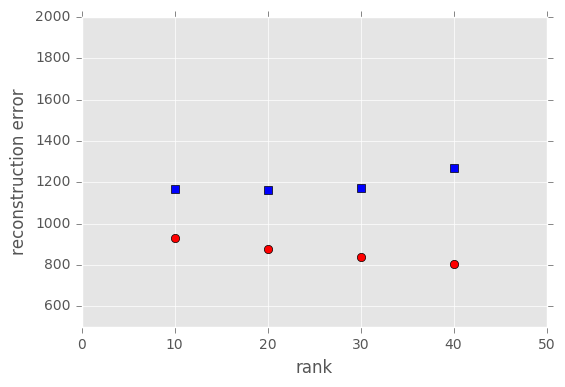

In [70]:
plt.plot([10,20,30,40], reconsError, 'ro') #Red circles represent SVD
plt.plot([10,20,30,40], reconsErrorCUR, 'bs') #Blue squares represent CUR
plt.axis([0,50,500,2000])
plt.xlabel('rank')
plt.ylabel('reconstruction error')
plt.show()


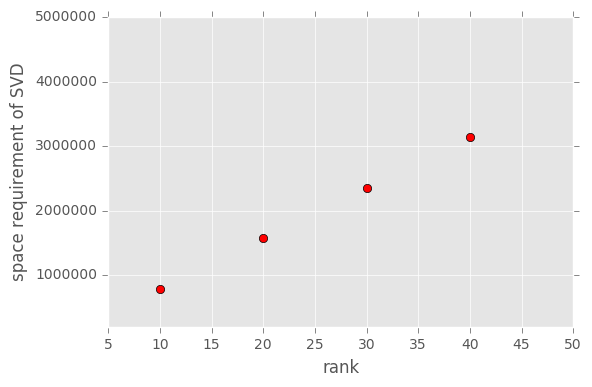

In [77]:
plt.plot([10,20,30,40], memoryTrajectory, 'ro') 
plt.axis([5,50,200000,5000000])
plt.xlabel('rank')
plt.ylabel('space requirement of SVD')
plt.show()

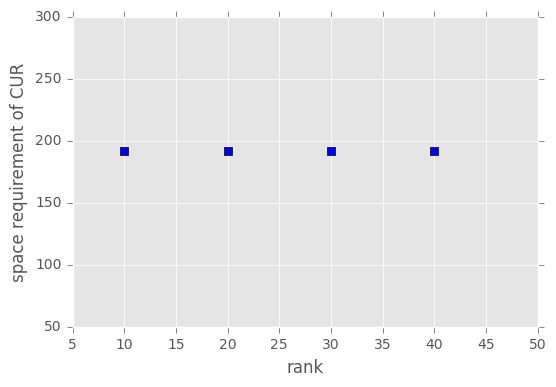

In [82]:
plt.plot([10,20,30,40], memoryTrajectoryCUR, 'bs') 
plt.axis([5,50,50,300])
plt.xlabel('rank')
plt.ylabel('space requirement of CUR')
plt.show()

# Visualizing SVD for a small test matrix

In [91]:
t=[[2,3,4,56],[2,3,7,6],[1,2,4,5],[1,2,4,5],[2,7,0,56],[55,45,66,9],[3,4,5,1]]
t=np.matrix(t)

In [92]:
x,y,z=SVD(t,t*t.T,t.T*t,4)

Eigenvectors and EigenValues calculated
proceeding...
stacking U and V matrices
constructing sigma matrix
done


In [96]:
t_r=x*y*z.T

In [97]:
norm(t-t_r)

3.0438760146533728e-13

In [98]:
t_r

matrix([[  2.00000000e+00,   3.00000000e+00,   4.00000000e+00,
           5.60000000e+01],
        [  2.00000000e+00,   3.00000000e+00,   7.00000000e+00,
           6.00000000e+00],
        [  1.00000000e+00,   2.00000000e+00,   4.00000000e+00,
           5.00000000e+00],
        [  1.00000000e+00,   2.00000000e+00,   4.00000000e+00,
           5.00000000e+00],
        [  2.00000000e+00,   7.00000000e+00,   1.34336986e-13,
           5.60000000e+01],
        [  5.50000000e+01,   4.50000000e+01,   6.60000000e+01,
           9.00000000e+00],
        [  3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
           1.00000000e+00]])